In [1]:
]activate .; instantiate

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [2]:
using Flux, Flux.Data.MNIST, Images
using Flux: onehotbatch, mse, throttle
using Base.Iterators: partition
using Images
#using CuArrays

For this model we'll learn a compression scheme. The idea is to encode MNIST digits as small vectors that can then be decoded back into the original image.

In [3]:
imgs = MNIST.images()
vecs = float.(vec.(imgs))

# Partition into batches of size 1000
data = [gpu(hcat(vecs[i]...)) for i in partition(1:60_000, 1000)];
vecs = gpu.(vecs);

,,,,,,,,,

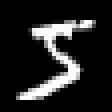
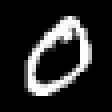
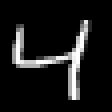
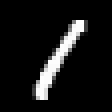
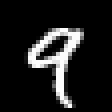
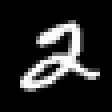
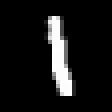
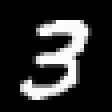
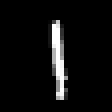
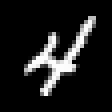

In [4]:
imgs[1:10]

In [5]:
N = 32 # Size of the encoding

encoder = Dense(28^2, N, relu)
decoder = Dense(N, 28^2, relu)

m = gpu(Chain(encoder, decoder))

loss(x) = mse(m(x), x)

loss (generic function with 1 method)

It's useful to be able to visualise what's happening in the network.

In [6]:
gray(x) = Gray(x)
img(x::AbstractVector) = collect(gray.(reshape(clamp.(x, 0, 1), 28, 28)))

img (generic function with 1 method)

First image:

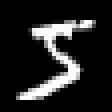

In [7]:
imgs[1]

Round-trip through the model:

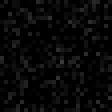

In [8]:
img(m(vecs[1]).data)

Random selection of 20 images:

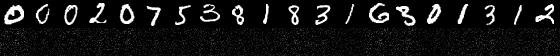

In [9]:
function sample()
  # 20 random digits
  xs = [vecs[i] for i in rand(1:length(imgs), 20)]
  # Before and after images
  before, after = img.(xs), img.(map(x -> m(x).data, xs))
  # Stack them all together
  hcat(vcat.(before, after)...)
end
sample()

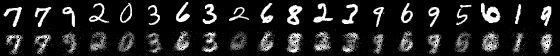

Loss is 70.60745969048207 (tracked)Loss is 55.598865591264754 (tracked)

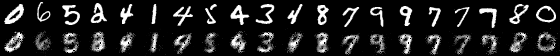

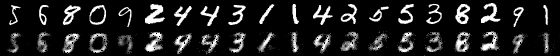

Loss is 48.22442489283083 (tracked)Loss is 41.03974710588153 (tracked)

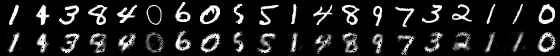

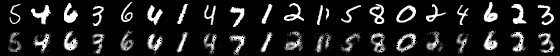

Loss is 33.05107107879027 (tracked)Loss is 25.723102981047873 (tracked)

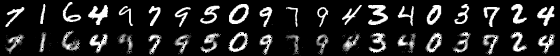

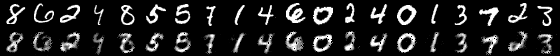

Loss is 19.397764217608668 (tracked)Loss is 14.638352487475323 (tracked)

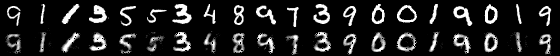

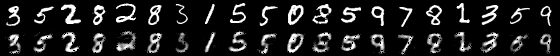

Loss is 11.211978689819983 (tracked)Loss is 9.030565163678538 (tracked)

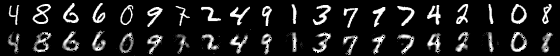

In [11]:
evalcb = function ()
    printstyled("Loss is $(loss(data[1][1]))", color=:blue)
    display(sample())
end
opt = ADAM(params(m))

for i = 1:10
    Flux.train!(loss, zip(data), opt)
    evalcb()
end